## Feature Engineering

In diesem Notebook werden die zur Modellierung verwendeten Features systematisch vorbereitet. Dabei werden auf Basis der in der explorativen Datenanalyse gewonnenen Erkenntnisse irrelevante Merkmale entfernt, kategoriale Merkmale kodiert und zusätzliche, abgeleitete Merkmale erzeugt.


## 1. Daten vorbereiten

Zunächst wird die Zielvariable `Machine failure` extrahiert und nicht benötigte Spalten aus dem Datensatz entfernt. Die Verteilung der Zielvariable wurde bereits im EDA-Notebook analysiert und wird hier nicht erneut dargestellt.


In [106]:
# Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Laden der Daten
df = pd.read_csv("../data/AI4I2020.csv")

# Zielvariable extrahieren
y = df["Machine failure"]

# Nicht-prädiktive Spalten entfernen
df = df.drop(columns=["UDI", "Product ID"])


## 2. Abgeleitete Merkmale (Feature-Konstruktion)

Bevor die Dummy-Codierung der Produkttypen erfolgt, werden die zusätzlichen Merkmale berechnet. Dies stellt sicher, dass sie in allen Folge-DataFrames (mit Dummy-Variablen) enthalten sind.

Auf Grundlage der vorangegangenen explorativen Analyse wurden vier neue Merkmale abgeleitet, die potenziell hilfreich für die Vorhersage von Maschinenfehlern sind:

- `Temp_Diff`: Temperaturdifferenz zwischen Prozess- und Umgebungstemperatur
- `Tool_wear_margin`: verbleibende Werkzeuglaufzeit bis zur Verschleißgrenze
- `Torque_per_rpm`: Verhältnis von Drehmoment zu Drehzahl (mechanische Belastung)
- `active_errors`: Summe der aktiven Fehlerarten (TWF, HDF, PWF, OSF, RNF)

Diese Features kombinieren physikalisches Verständnis mit datengetriebener Trennschärfe.




In [107]:
# Neue Features berechnen
df["Temp_Diff"] = df["Process temperature [K]"] - df["Air temperature [K]"]
df["Tool_wear_margin"] = 240 - df["Tool wear [min]"]
df["Torque_per_rpm"] = df["Torque [Nm]"] / df["Rotational speed [rpm]"]
df["active_errors"] = df[["TWF", "HDF", "PWF", "OSF", "RNF"]].sum(axis=1)


## 3. One-Hot-Encoding der Produkttypen

Nach der Feature-Konstruktion wird das kategoriale Merkmal `Type` mittels One-Hot-Encoding in Dummy-Variablen umgewandelt.
Die Spalte `Type` beschreibt den Produkttyp (H, L, M) und ist ein kategoriales Merkmal. Um sie in maschinenlesbare Form zu bringen, wird sie mittels One-Hot-Encoding in binäre Indikatorvariablen umgewandelt. Dabei wird je nach Modellanforderung unterschiedlich kodiert.

### 3.1 One-Hot-Encoding: zwei Varianten

Zur Vorbereitung auf verschiedene Modelltypen wird `Type` in zwei Varianten kodiert:

- **Variante A (`drop_first=True`)**: Für Modelle, die keine Multikollinearität vertragen (z. B. logistische Regression). Dabei wird eine der drei Klassen (hier: `Type_H`) weggelassen und implizit als Referenz interpretiert.
- **Variante B (`drop_first=False`)**: Für baumbasierte Modelle (Random Forest, XGBoost, SHAP-Analyse), bei denen alle Produkttypen explizit modelliert und interpretiert werden sollen.

Im Anschluss werden zur Kontrolle die erzeugten Dummy-Variablen beider Varianten angezeigt.

**Hinweis:** Die erzeugten Dummy-Variablen erscheinen zunächst im Format `True`/`False`. Dies entspricht intern den binären Werten `1` und `0` und ist für Machine-Learning-Algorithmen uneingeschränkt verwendbar. Optional können die Werte zur besseren Lesbarkeit in Integer (`int`) umgewandelt werden.


In [108]:
# Variante 1: mit drop_first=True (reduzierte Dummy-Codierung)
df_dummies_reduced = pd.get_dummies(df, columns=["Type"], drop_first=True)

# Variante 2: mit allen Typen (für Random Forest, XGBoost, SHAP etc.)
df_dummies_full = pd.get_dummies(df, columns=["Type"], drop_first=False)

# Nur die Dummy-Spalten (Variante mit drop_first=True)
print("Dummy-Variablen (drop_first=True):")
display(df_dummies_reduced.filter(like="Type_").head())

# Nur die Dummy-Spalten (drop_first=False)
print("Dummy-Variablen (drop_first=False):")
display(df_dummies_full.filter(like="Type_").head())



Dummy-Variablen (drop_first=True):


,Type_L,Type_M
0,False,True
1,True,False
2,True,False
3,True,False
4,True,False


Dummy-Variablen (drop_first=False):


,Type_H,Type_L,Type_M
0,False,False,True
1,False,True,False
2,False,True,False
3,False,True,False
4,False,True,False


## 4. Auswahl der finalen Features

Die finale Feature-Matrix enthält sowohl originale Merkmale als auch neu berechnete Features und die Dummy-kodierten Produkttypen. Die Auswahl basiert auf der explorativen Analyse und fachlich plausiblen Zusammenhängen mit der Zielvariable.

Es wurden zwei Varianten vorbereitet:
- `X`: enthält die reduzierte Dummy-Codierung (`Type_L`, `Type_M`)
- `X_full`: enthält alle Produkttypen explizit (`Type_H`, `Type_L`, `Type_M`)

Beide Varianten können abhängig vom Modelltyp verwendet werden.


In [109]:
selected_features = [
    "Air temperature [K]",
    "Process temperature [K]",
    "Rotational speed [rpm]",
    "Torque [Nm]",
    "Tool wear [min]",
    "Type_L", "Type_M",  # Type_H kommt gleich optional dazu
    "Temp_Diff",
    "Tool_wear_margin",
    "Torque_per_rpm",
    "active_errors"
]

# Feature-Matrix mit reduzierter Dummy-Kodierung
X_reduced = df_dummies_reduced[selected_features]

# Feature-Matrix mit vollständiger Dummy-Kodierung
X_full = df_dummies_full[selected_features + ["Type_H"]]





## 5. Korrelationsmatrix der Feature-Matrix

Für die Korrelationsanalyse wurde die reduzierte Feature-Matrix X_reduced verwendet. Diese enthält zwei Dummy-Variablen zur Kodierung der Produkttypen (Type_L, Type_M) und vermeidet die künstliche Korrelation durch vollständige Dummy-Dekodierung (Multikollinearität).

Die folgende Heatmap zeigt die paarweisen Korrelationen der finalen Features. Dies dient dazu, Zusammenhänge und potenzielle Redundanzen (z. B. starke lineare Abhängigkeiten) zu erkennen. Hohe positive oder negative Korrelationen können auf strukturell ähnliche Informationen hinweisen.

Die Ergebnisse zeigen erwartungsgemäß starke Zusammenhänge zwischen bestimmten Merkmalen:

- `Air temperature` und `Process temperature` sind stark positiv korreliert (+0.88)
- `Rotational speed` und `Torque` zeigen eine stark negative Korrelation (–0.88), was physikalisch sinnvoll ist
- Die abgeleiteten Features `Tool_wear_margin` und `Torque_per_rpm` sind nahezu vollständig mit den Ursprungsspalten korreliert. Diese Merkmale sind redundant, können aber je nach Modellinterpretation vorteilhaft sein

Redundante Features werden im weiteren Verlauf beobachtet, aber nicht vorab ausgeschlossen, um Modelle wie Random Forest oder XGBoost mit Feature-Importance-Analysen zu nutzen.

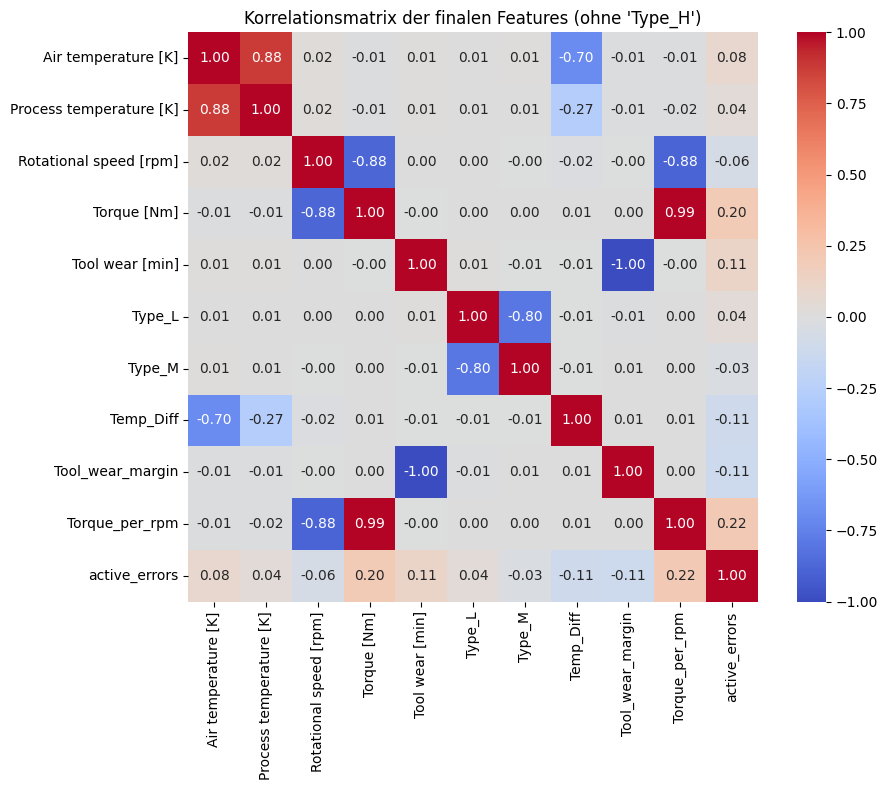

In [110]:
# Korrelationen berechnen
corr = X_reduced.corr()

# Heatmap zeichnen
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Korrelationsmatrix der finalen Features (ohne 'Type_H')")
plt.tight_layout()
plt.show()

## 6. Boxplots: Feature-Verteilung nach Zielvariable

Die folgenden Boxplots zeigen die Verteilung ausgewählter Merkmale gruppiert nach der Zielvariable `Machine failure`. Besonders deutlich ist der Unterschied bei:

Insbesondere die Merkmale `Torque`, `Tool wear`, `Torque_per_rpm` und `Tool_wear_margin` zeigen deutliche Unterschiede in ihrer Verteilung. Diese Merkmale eignen sich besonders gut für den Einsatz in Klassifikationsmodellen.

Demgegenüber weisen Temperaturmerkmale wie `Air temperature`, `Process temperature` sowie deren Differenz `Temp_Diff` nur geringe Unterschiede zwischen den Klassen auf. Sie werden dennoch berücksichtigt, da sie ggf. in Kombination mit anderen Merkmalen relevant sind.

Das abgeleitete Merkmal `active_errors` zeigt klar, dass fehlerhafte Maschinenzustände fast immer mit mindestens einem aktiven Fehlercode verbunden sind.

Diese Beobachtungen stützen die Auswahl der Features für die nachfolgenden Klassifikationsmodelle.


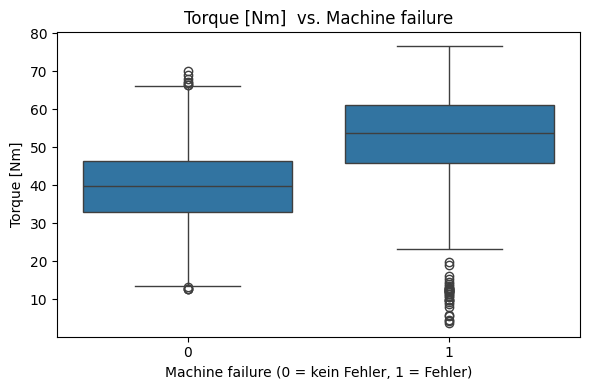

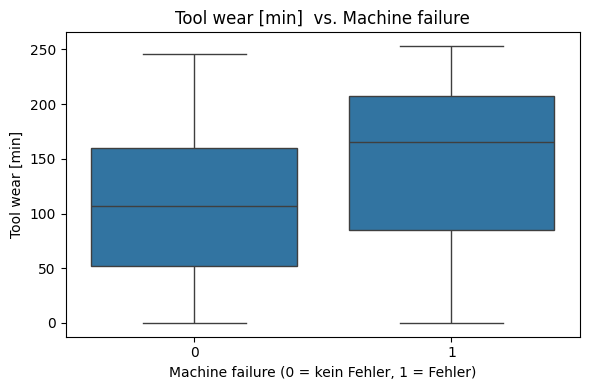

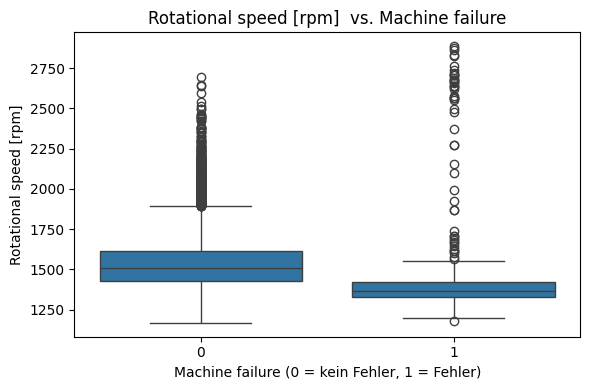

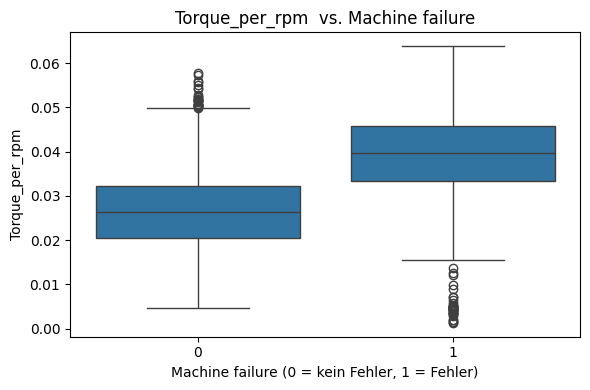

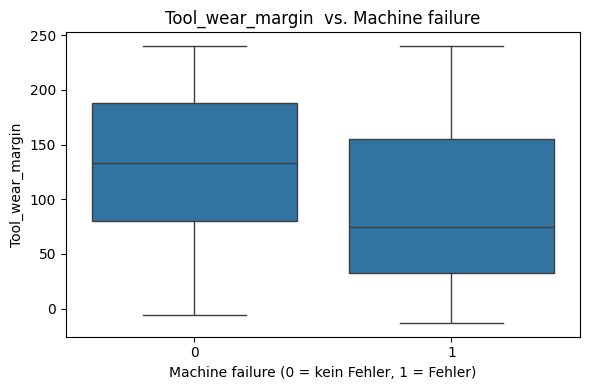

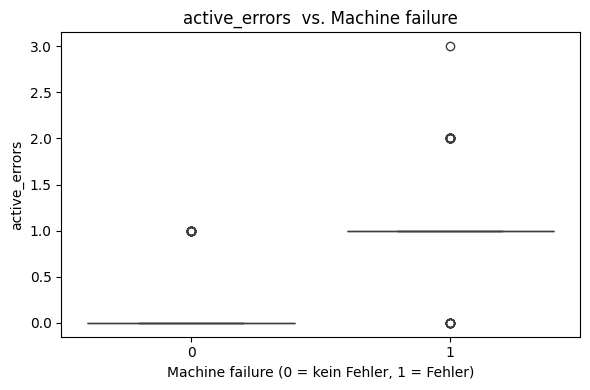

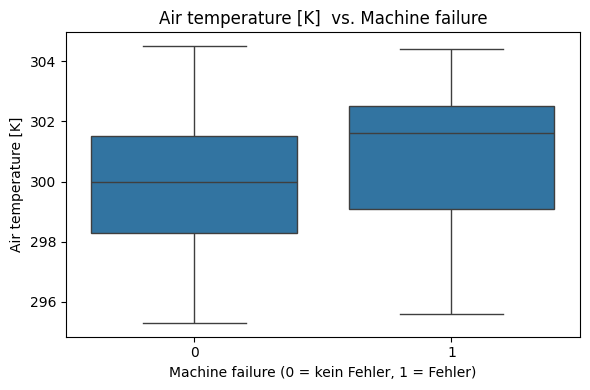

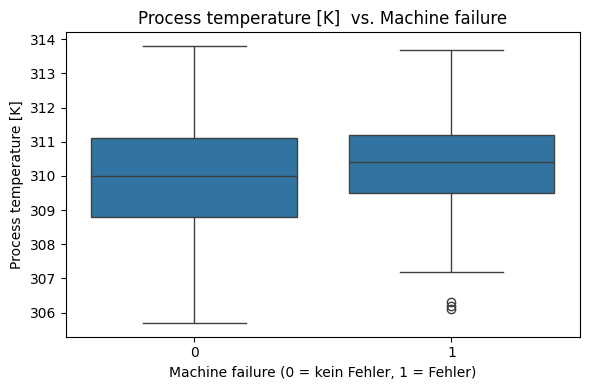

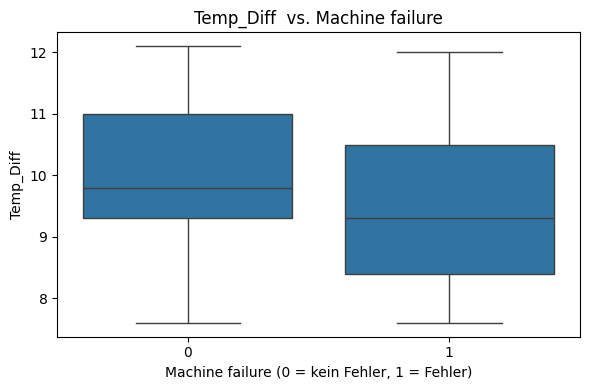

In [111]:
# Liste relevanter Features
plot_features = [
    "Torque [Nm]",
    "Tool wear [min]",
    "Rotational speed [rpm]",
    "Torque_per_rpm",
    "Tool_wear_margin",
    "active_errors",
    "Air temperature [K]",
    "Process temperature [K]",
    "Temp_Diff"
]

# Boxplots erzeugen
for feature in plot_features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df, x="Machine failure", y=feature)
    plt.title(f"{feature}  vs. Machine failure")
    plt.xlabel("Machine failure (0 = kein Fehler, 1 = Fehler)")
    plt.ylabel(feature)
    plt.tight_layout()
    plt.show()

## 7. Vorbereitung: Train/Test-Split, Skalierung und Datenexport

Da verschiedene Modelltypen eingesetzt werden (Random Forest, XGBoost, Autoencoder, logistische Regression), werden zwei Varianten der Feature-Matrix verwendet:

- `X_full`: Enthält alle Dummy-Variablen (`Type_H`, `Type_L`, `Type_M`) – wird für Random Forest, XGBoost und Autoencoder verwendet.
- `X_reduced`: Verzichtet auf die Referenz-Dummyvariable (`Type_H`) – wird für die logistische Regression verwendet, um Multikollinearität zu vermeiden.

Anschließend erfolgt ein stratifizierter Train/Test-Split (80/20) auf identischer Stichprobe. Für Modelle wie Autoencoder (und optional LogReg) wird eine Standardisierung per `StandardScaler` durchgeführt.  

Für den Autoencoder werden ausschließlich fehlerfreie Instanzen (`Machine failure = 0`) als Trainingsdaten verwendet, um normales Maschinenverhalten zu modellieren.

### Exportierte Dateien (../data/)
Die folgenden Datenobjekte werden im `data/`-Ordner gespeichert und in den Modellierungs-Notebooks wiederverwendet:

- **Train/Test-Datensätze (unskaliert):**  
  - `X_train.pkl`, `X_test.pkl` → für Random Forest & XGBoost  
  - `X_train_reduced.pkl`, `X_test_reduced.pkl` → für logistische Regression

- **Zielvariable:**  
  - `y_train.pkl`, `y_test.pkl`

- **Skalierte Matrizen:**  
  - `X_train_scaled.pkl`, `X_test_scaled.pkl` → für Autoencoder  
  - `X_train_reduced_scaled.pkl`, `X_test_reduced_scaled.pkl` → optional für LogReg

- **Nur fehlerfreie Trainingsdaten:**  
  - `X_train_autoencoder.pkl` → Trainingsbasis für Autoencoder

- **Skalierungsobjekt:**  
  - `standard_scaler.pkl` → wird im Inferenzskript wiederverwendet

Durch den Export wird die Datenvorverarbeitung modular gehalten und kann in separaten Modellierungs-Notebooks direkt wiederverwendet werden.


In [112]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
import os
import pandas as pd

# Zielvariable definieren
y = df["Machine failure"]

# Zwei Varianten der Feature-Matrix:
X_full = df_dummies_full[selected_features + ["Type_H"]]     # Für RF, XGB, Autoencoder
X_reduced = df_dummies_reduced[selected_features]            # Für Logistic Regression

# 1. Train/Test-Split für beide Varianten (identisch aufgeteilt!)
X_train_full, X_test_full, y_train, y_test = train_test_split(
    X_full, y, test_size=0.2, stratify=y, random_state=42
)

X_train_reduced, X_test_reduced, _, _ = train_test_split(   # gleiche Aufteilung wie oben
    X_reduced, y, test_size=0.2, stratify=y, random_state=42
)

# 2. Skalierung für Modelle, die sie benötigen (Autoencoder, optional LogReg)
scaler = StandardScaler()
X_train_full_scaled = scaler.fit_transform(X_train_full)
X_test_full_scaled = scaler.transform(X_test_full)

X_train_reduced_scaled = scaler.fit_transform(X_train_reduced)
X_test_reduced_scaled = scaler.transform(X_test_reduced)

# 3. Trainingsdaten für Autoencoder: nur fehlerfreie Beobachtungen
X_train_ae = X_train_full_scaled[y_train == 0]

# 4. Export der Daten in ../data/
os.makedirs("../data", exist_ok=True)

# Unskalierte Daten (RF, XGB)
pd.DataFrame(X_train_full, columns=X_full.columns).to_pickle("../data/X_train.pkl")
pd.DataFrame(X_test_full, columns=X_full.columns).to_pickle("../data/X_test.pkl")

# Zielvariable
y_train.to_pickle("../data/y_train.pkl")
y_test.to_pickle("../data/y_test.pkl")

# Reduzierte Variante für LogReg
pd.DataFrame(X_train_reduced, columns=X_reduced.columns).to_pickle("../data/X_train_reduced.pkl")
pd.DataFrame(X_test_reduced, columns=X_reduced.columns).to_pickle("../data/X_test_reduced.pkl")

# Skalierte Daten (Autoencoder, optional LogReg)
joblib.dump(X_train_full_scaled, "../data/X_train_scaled.pkl")
joblib.dump(X_test_full_scaled, "../data/X_test_scaled.pkl")
joblib.dump(X_train_reduced_scaled, "../data/X_train_reduced_scaled.pkl")
joblib.dump(X_test_reduced_scaled, "../data/X_test_reduced_scaled.pkl")

# Nur fehlerfreie Beobachtungen für Autoencoder
joblib.dump(X_train_ae, "../data/X_train_autoencoder.pkl")

# Skaler speichern
joblib.dump(scaler, "../data/standard_scaler.pkl")

print("✅ Alle Features und Zielvariablen wurden erfolgreich exportiert.")


✅ Alle Features und Zielvariablen wurden erfolgreich exportiert.
